# **Dataset 4**
### **OULAD StudentInfo.csv**

#### **Import Packages**

In [1]:
import os
import sys
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia


### **Exploratory Data Analysis**

In [2]:
# Load dataset as dataframe
data_path = "../data/original_data/4_open_university/4_open_university.csv"
original_data = pd.read_csv(data_path)
original_data.head()


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [4]:
# Check for missing values
original_data.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

Found 1111 missing values in column 'imd_band'. Replace with mode.

In [5]:
original_data["imd_band"].fillna(original_data["imd_band"].mode()[0], inplace=True)
original_data.isnull().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

<Axes: xlabel='final_result', ylabel='Count'>

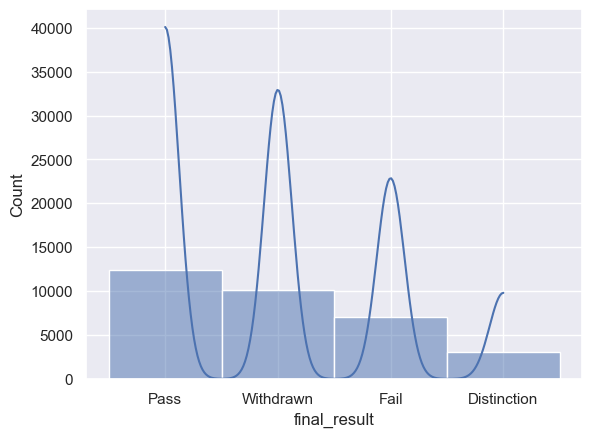

In [6]:
# Check score distribution
sns.histplot(original_data['final_result'], kde=True)

In [7]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

code_module ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
code_presentation ['2013J' '2014J' '2013B' '2014B']
gender ['M' 'F']
region ['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']
highest_education ['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']
imd_band ['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' '60-70%' '40-50%'
 '10-20' '0-10%']
age_band ['55<=' '35-55' '0-35']
disability ['N' 'Y']
final_result ['Pass' 'Withdrawn' 'Fail' 'Distinction']


In [8]:
# Replace certrain characters to make it work with DataSynthesizer
to_replace = {'-':' to ', '55<=': '55 to 100'}
original_data['age_band'].replace(to_replace=to_replace, regex=True, inplace=True)

# replace % character in imd_band column
original_data['imd_band'].replace('%', 'pct', regex=True, inplace=True)
original_data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100pct,55 to 100,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30pct,35 to 55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40pct,35 to 55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60pct,35 to 55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60pct,0 to 35,0,60,N,Pass


### **Synthetic Data Generation**

In [13]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

original_data_path = "../data/original_data/4_open_university/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

# Prüfen, ob beide Dateien existieren
if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data saved.


In [9]:
synth_path = "../data/synthetic_data/4_open_university/"
dataset_name = "4_open_university"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]

if len(csv_files) == 0:
    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    arguments = [data_path, str(n), dataset_name]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [10]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

train_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/synthetic_data/4_open_university/synthpop.csv'

### **Utility Evaluation**

Prepare utility evaluation

In [11]:
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "final_result"

NameError: name 'synthpop' is not defined

Run random forest classifier for utility evaluation

In [12]:
rf_results = {}
rf_df = pd.read_csv("../data/results/tables/rf.csv")
rows = []

if (rf_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "random_forest")

        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([6, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=rf_df.columns)
    rf_df = pd.concat([rf_df, rows])
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)
    rf_df.head()

NameError: name 'synth_datasets' is not defined

Run logistic regression for utility evaluation

In [14]:
lr_results = {}
lr_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (lr_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([6, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=lr_df.columns)
    lr_df = pd.concat([lr_df, rows])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)
    lr_df.tail(7)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
23,5,ctgan,0.23,0.21,0.25
0,6,synthpop,0.00,0.01,-0.01
1,6,ds,0.01,0.03,0.06
2,6,tvae,0.01,0.03,0.01
3,6,gaussian_copula,0.03,0.12,0.05
4,6,copula_gan,0.01,0.02,0.00
5,6,ctgan,0.03,-0.01,0.00


Run multilayer perceptron (MLP)

In [15]:
mlp_results = {}
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")
rows = []

if (lr_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([6, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=mlp_df.columns)
    mlp_df = pd.concat([mlp_df, rows])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)
    mlp_df.tail(7)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
23,5,ctgan,0.25,0.20,0.18
0,6,synthpop,0.00,0.00,0.01
1,6,ds,-0.08,-0.07,0.01
2,6,tvae,0.00,0.00,0.01
3,6,gaussian_copula,0.00,0.00,0.01
4,6,copula_gan,-0.08,-0.10,-0.01
5,6,ctgan,0.07,0.06,0.01


### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [16]:
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")
rows = []

if (corr_diff_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_dataset)
        rows.append([6,model_names[i], result])

    rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
    corr_diff_df = pd.concat([corr_diff_df, rows])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)
    corr_diff_df.tail(7)

,Dataset,Model,Pairwise Corr Diff
23,5,ctgan,0.081352
0,6,synthpop,0.012857
1,6,ds,0.036573
2,6,tvae,0.022943
3,6,gaussian_copula,0.037979
4,6,copula_gan,0.044427
5,6,ctgan,0.027616


**Jensen-Shannon Divergence**

In [17]:
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")
rows = []

if (jsd_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = jsd(train_data, synth_dataset)
        rows.append([6,model_names[i], result])

    rows = pd.DataFrame(rows, columns=jsd_df.columns)
    jsd_df = pd.concat([jsd_df, rows])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)
    jsd_df.tail(7)

,Dataset,Model,JSD Diff
23,5,ctgan,0.012078
0,6,synthpop,0.034269
1,6,ds,0.114744
2,6,tvae,0.080144
3,6,gaussian_copula,0.107406
4,6,copula_gan,0.079495
5,6,ctgan,0.066115


**Wasserstein Distance**

In [18]:
wd_df = pd.read_csv("../data/results/tables/wd.csv")
rows = []

if (wd_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = wd(train_data, synth_dataset)
        rows.append([6,model_names[i], result])

    rows = pd.DataFrame(rows, columns=wd_df.columns)
    wd_df = pd.concat([wd_df, rows])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)
    wd_df.tail(7)

,Dataset,Model,WD Diff
23,5,ctgan,0.045989
0,6,synthpop,0.006354
1,6,ds,0.015620
2,6,tvae,0.030043
3,6,gaussian_copula,0.006366
4,6,copula_gan,0.030911
5,6,ctgan,0.026413


### **Privacy**

Run privacy evaluation using Distance to closest Record (DCR), Nearest Neighbour Difference Ratio (NNDR) and Membership Inference Attack (MIA)

- **DCR**: a value of zero indicates that the synthetic record is an identical copy of the original
one -> leak of real information, higher values indicate more privacy

- **NNDR**: ratio is within [0,1], higher values indicate better privacy

- **MIA**: both accuracy and precision should be below 0.5 for all thresholds for strong privacy preservation

**Distance to closest record (DCR)**

In [20]:
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")
rows = []

if (dcr_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Original", save_hist=True)
        result_within_synth = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Synthetic", save_hist=True)
        rows.append([6,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=dcr_df.columns)
    dcr_df = pd.concat([dcr_df, rows])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)
    dcr_df.tail(7)

,Dataset,Model,DCR 5th Percentile,DCR 5th Percentile (within Real),DCR 5th Percentile (within Synthetic)
29,6,ctgan,6.164,2.236,9.157
0,6,synthpop,2.449,2.236,5.099
1,6,ds,10.293,2.236,15.492
2,6,tvae,5.916,2.236,8.000
3,6,gaussian_copula,13.075,2.236,22.627
4,6,copula_gan,6.708,2.236,10.812
5,6,ctgan,6.164,2.236,9.157


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [21]:
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")
rows = []

if (nndr_df["Dataset"] == 4).any():
    print("Entry for '4_open_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = nndr(train_data, synth_dataset)
        result_within_real = nndr(train_data, synth_dataset, within="Original")
        result_within_synth = nndr(train_data, synth_dataset, within="Synthetic")
        rows.append([6,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=nndr_df.columns)
    nndr_df = pd.concat([nndr_df, rows])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)
    nndr_df.tail(7) 

,Dataset,Model,NNDR 5th percentile,NNDR 5th percentile (within Real),NNDR 5th percentile (within Synthetic)
23,5,ctgan,0.768,0.775,0.832
0,6,synthpop,0.045,0.073,0.065
1,6,ds,0.212,0.073,0.151
2,6,tvae,0.203,0.073,0.114
3,6,gaussian_copula,0.132,0.073,0.114
4,6,copula_gan,0.196,0.073,0.143
5,6,ctgan,0.174,0.073,0.131


**Membership Inference Attack (MIA)**

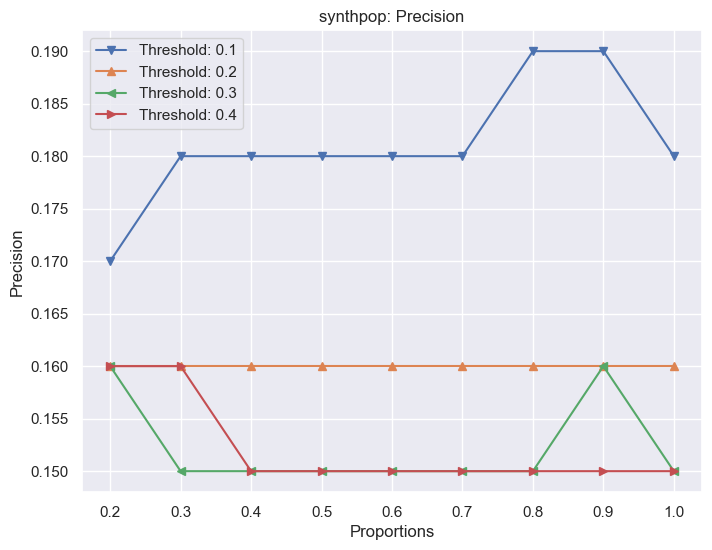

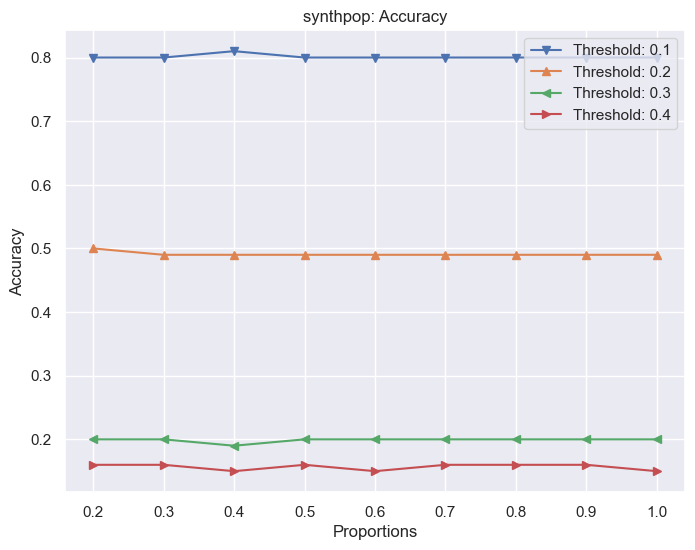

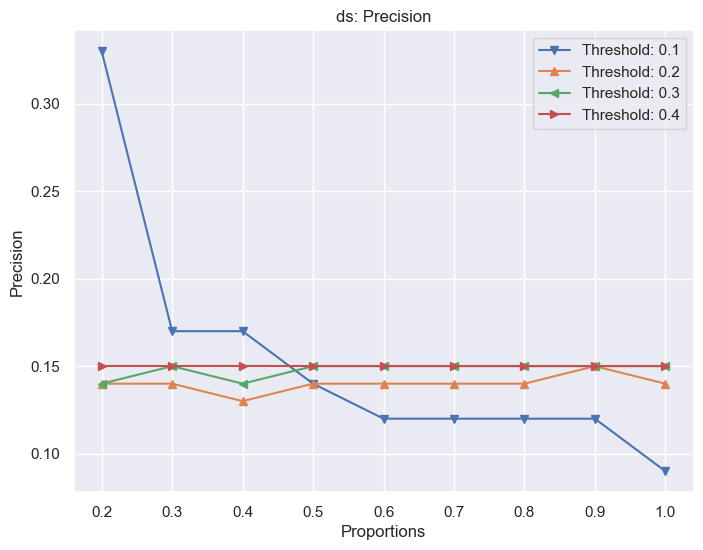

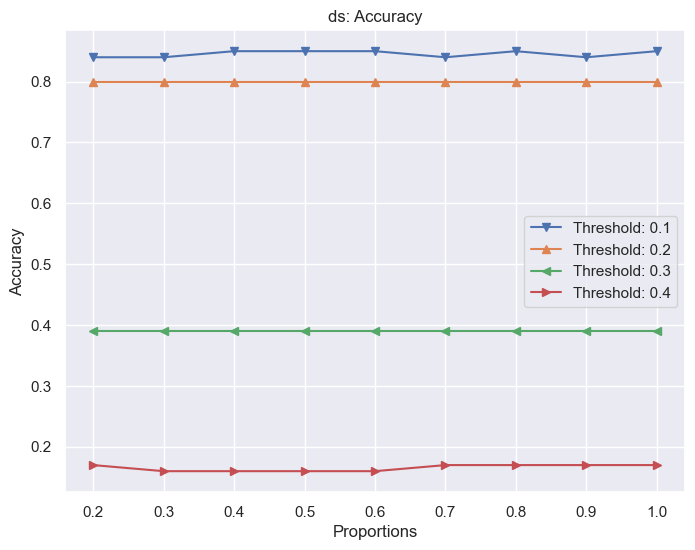

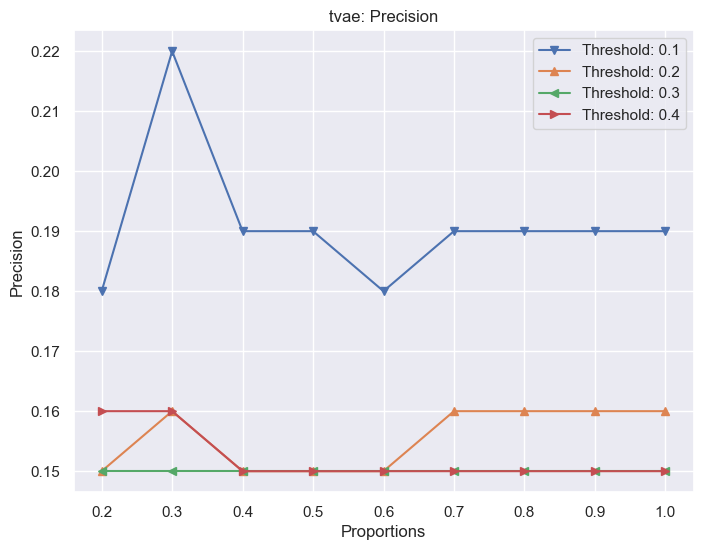

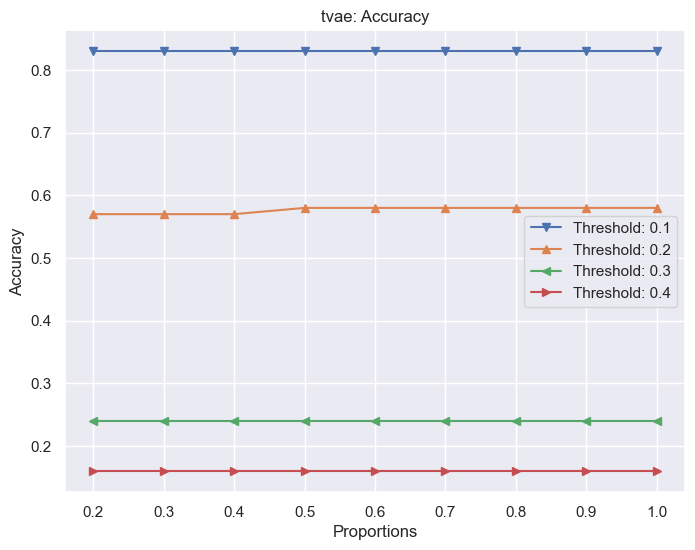

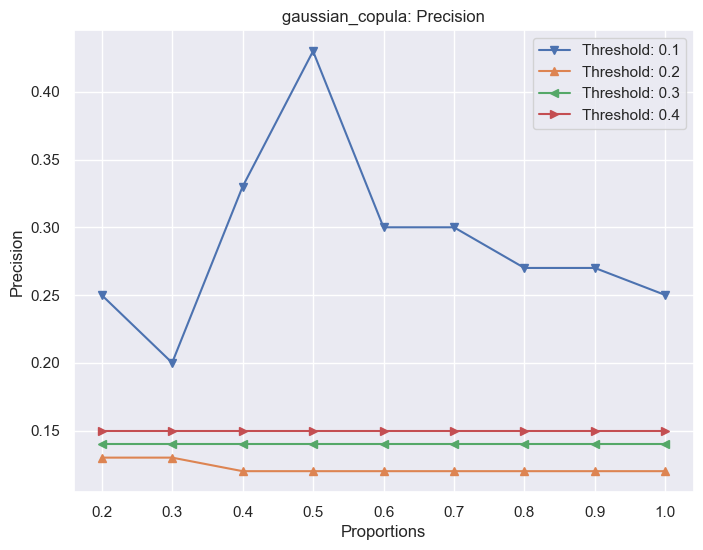

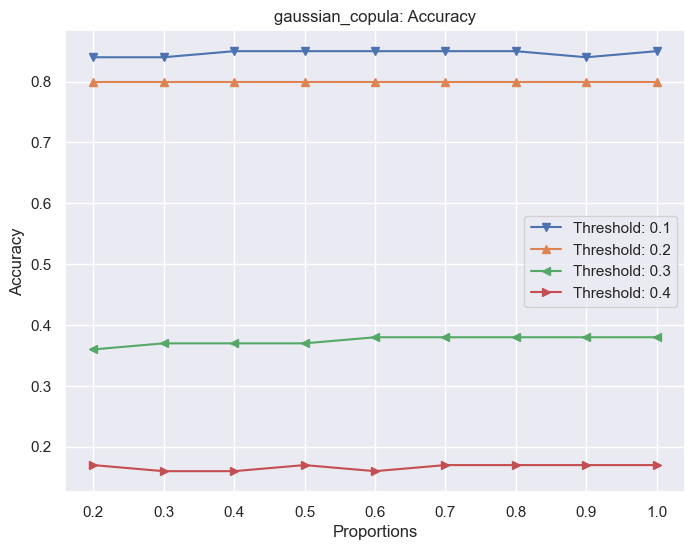

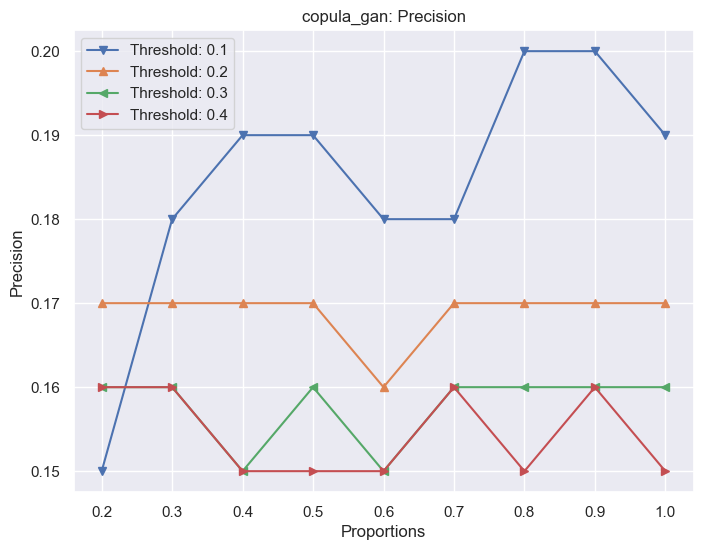

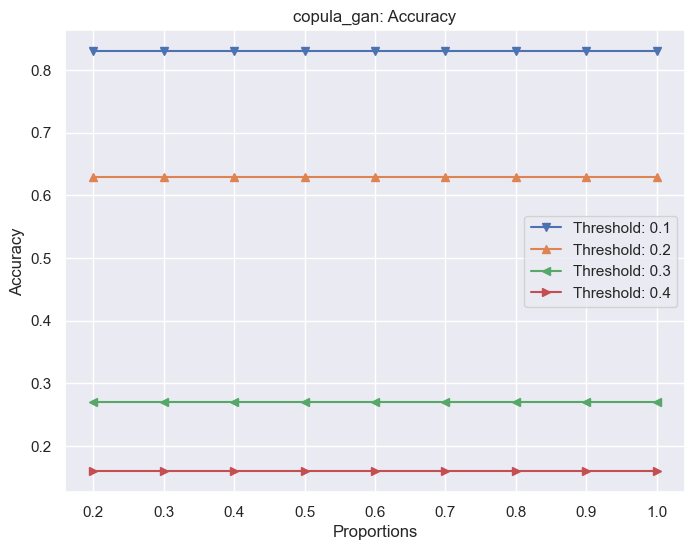

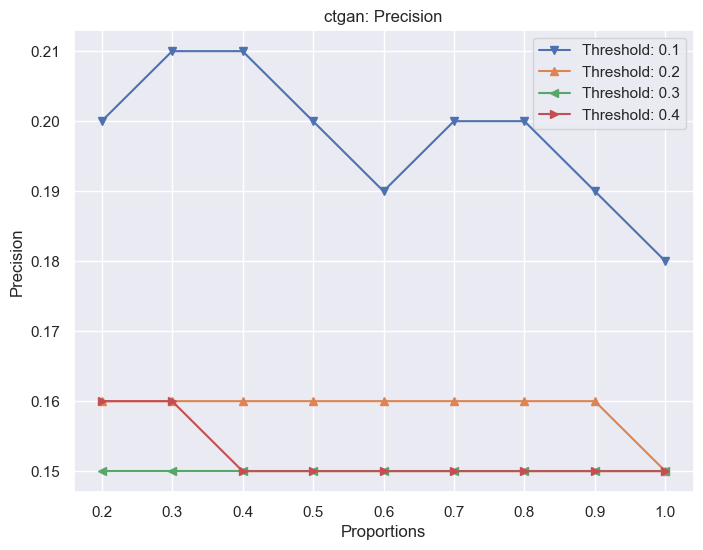

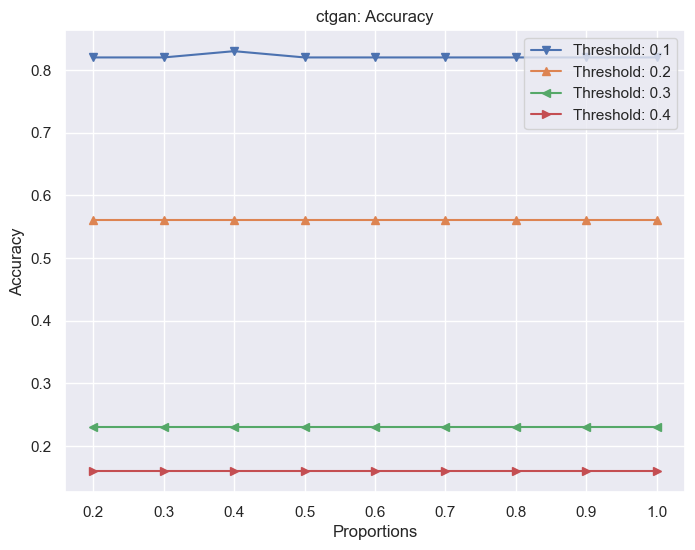

In [22]:
mia_results = {}
if (os.path.isfile("../data/results/plots/mia/4_open_university/ds_mia_accuracy.png")):
    print("MIA results already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)
